# <center>Рекуррентные нейронные сети</center>

<div style="width:50%; float:left">
<h2>Теория:</h2>        
<ul>
<li> <a href="#simpleRNN">SimpleRNN</a>
    <ul>
      <li> <a href="#many-to-one">Many-to-One</a>
      <li> <a href="#many-to-many">Many-to-Many</a>
      <li> <a href="#one-to-many">One-to-Many копированием</a>
      <li> <a href="#one-to-many2">Параметр stateful</a>               
    </ul>
<li> <a href="#LSTM">LSTM</a>
    <ul>
      <li> <a href="#LSTM_params">Число параметров</a>
      <li> <a href="#LSTM_activ">Активационные функции</a>
    </ul>    
</ul>
</div>
<div style="width:50%; float:right">
<h2>Примеры:</h2>    
<ul>
<li> <a href="#time_series">Временные ряды</a>
    <ul>
      <li> <a href="#ts_class">Класс TimeSeries</a>
      <li> <a href="#ts_1">Периодическая функция</a>
      <li> <a href="#ts_2">Котировки Appl</a>    
    </ul>        
<li> <a href="#MNIST">MNIST</a>
<li> <a href="#stateful_example">Обучение с stateful=True</a>
</ul>
</div>
<div style="clear:both"></div>

<hr>

## Книги
* [Dive into Deep Learning](https://d2l.ai/d2l-en.pdf)  ( [on-line](https://d2l.ai/index.html) )
* [	Deep Learning with Keras](http://gen.lib.rus.ec/book/index.php?md5=DCFAA3D4F9D8702EE3534BEA90FD625C)
* [Advanced Deep Learning with Keras](http://gen.lib.rus.ec/book/index.php?md5=085D57E97969791851FE9CBB2BFB44A8)

## Полезная информация

* [The Unreasonable Effectiveness of Recurrent Neural Networks](http://karpathy.github.io/2015/05/21/rnn-effectiveness/)
* [Understanding LSTM Networks](http://colah.github.io/posts/2015-08-Understanding-LSTMs/)
* [Dive into Deep Learning](https://d2l.ai/chapter_recurrent-neural-networks/gru.html)
* [Time Series Prediction with LSTM Recurrent Neural Networks in Python with Keras](https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/)
* [A ten-minute introduction to sequence-to-sequence learning in Keras](https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html)

## SimpleRNN
<a class="anchor" id="SimpleRNN"></a>

Простая рекуррентная сеть в каждой ячейке вычисляет: 
$$
\mathbf{h}_t = f(\mathbf{x}_t,\mathbf{h}_{t-1}) ~=~ f(\mathbf{x}_t\cdot \mathbf{W} + \mathbf{h}_{t-1}\cdot \mathbf{H} + \mathbf{b}).
$$ 


<div style="margin:30px">
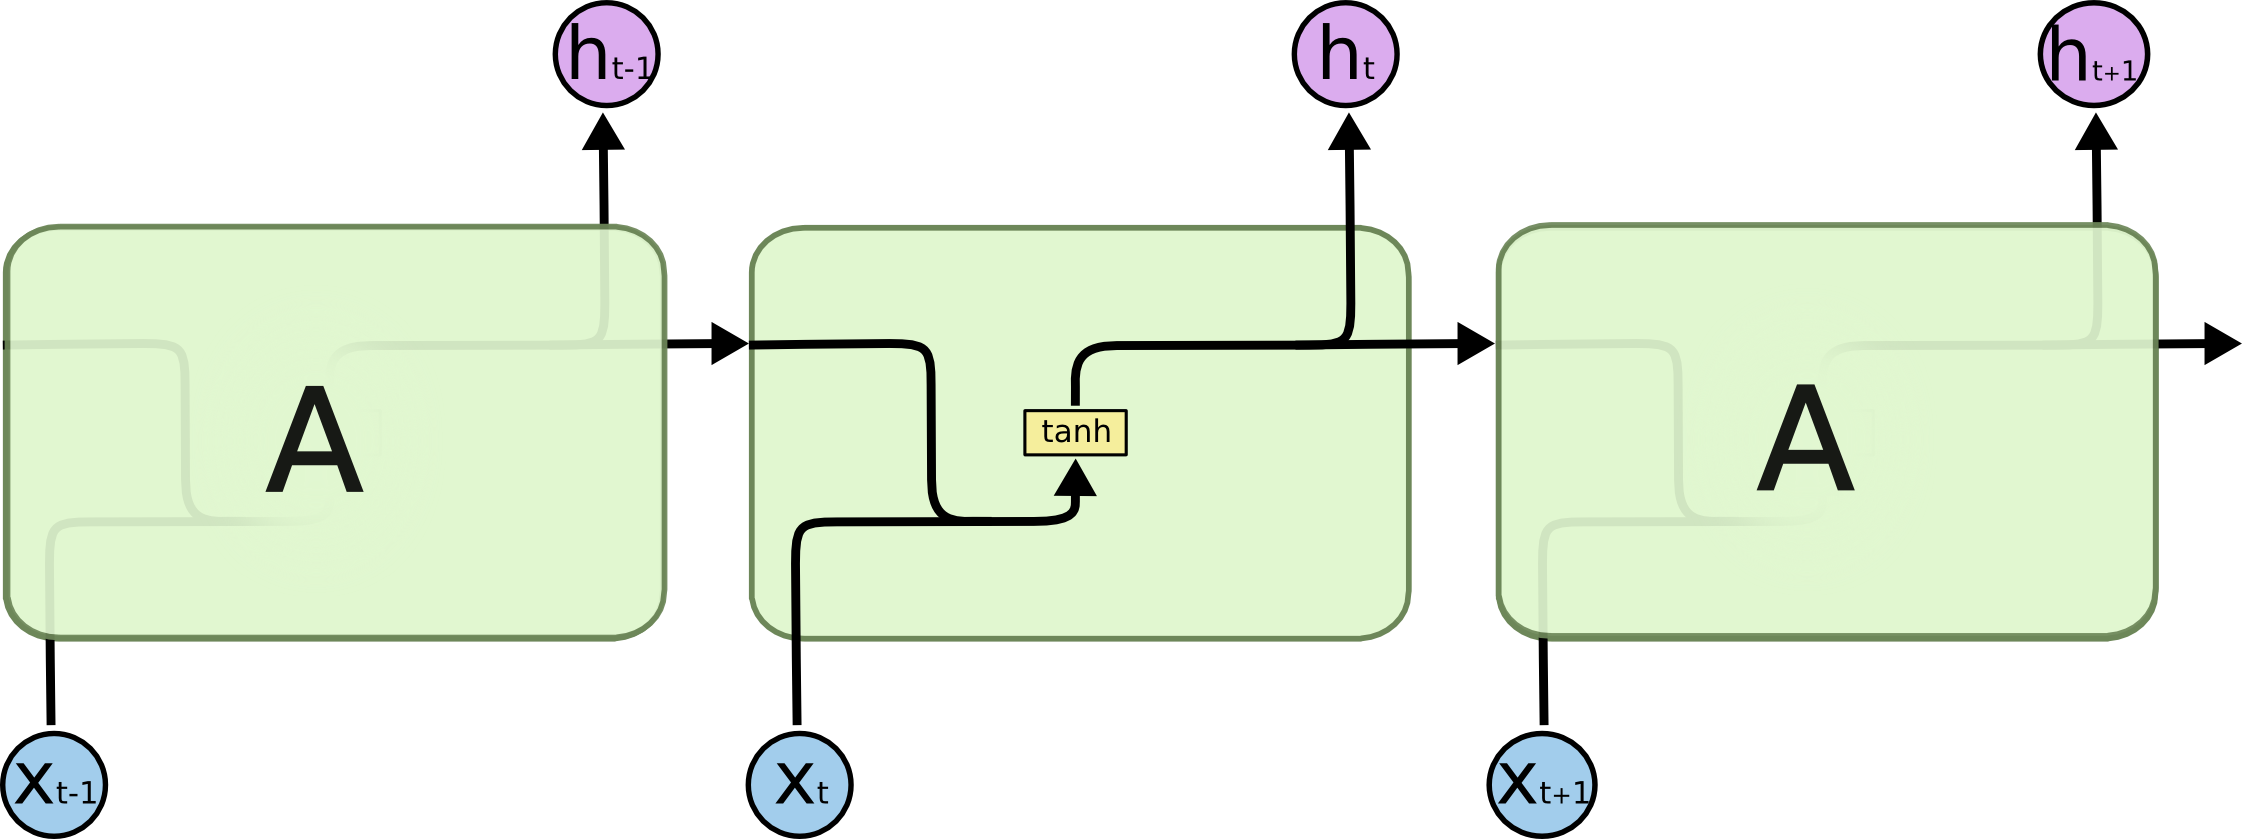
</div>

* Размерность вектора $\mathbf{x}_{t}$ - это число признаков (`features`). 
* Размерности выходов $\mathbf{h}_t$ слоя в Keras обозначается как `units`.
* Все ячейки **одинаковые**, поэтому число входов  на число параметров не влияеет.

Вектор признаков $\mathbf{x}_t$  слева умножается на матрицу весов $\mathbf{W}$, чтобы можно было добавлять к нему строки батча.
Например для размерности входа `features=3` и размерности выхода `units=2`:

$$
\begin{pmatrix}
x_{t,1} ~ x_{t,2} ~ x_{t,3} \\
\end{pmatrix}
\cdot
\begin{pmatrix}
W_{11} & W_{12} \\
W_{21} & W_{22} \\
W_{31} & W_{32} \\
\end{pmatrix}
+
\begin{pmatrix}
h_{t-1,1} ~ h_{t-1,2} \\
\end{pmatrix}
\cdot
\begin{pmatrix}
H_{11} & H_{12} \\
H_{21} & H_{22} \\
\end{pmatrix}
+
\begin{pmatrix}
b_{1} ~ b_{2} \\
\end{pmatrix}
=
\begin{pmatrix}
r_1 ~ r_2 \\
\end{pmatrix}
$$


Размерности матриц равны `W: (features, units),  H: (units, units),  b: ( units )`, а общее число параметров:
```
   params = (features + units + 1) * units
```
В случае пачки примеров (batch) строка смещения $(b_1~b_2)$ прибавляется к каждой строке матрицы, та как в numpy:

In [3]:
import numpy as np
np.array([[1,2], 
          [3,4], 
          [5,6]]) + np.array([1,1])

array([[2, 3],
       [4, 5],
       [6, 7]])

## Вывод структуры графа
<a id="svg_model"></a>

In [4]:
import os                                     # Надо поставить graphviz c www.graphviz.org
from IPython.display import SVG, display
from keras.utils.vis_utils import model_to_dot
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

def svg_model(model):
    """ Выводит модель нейронной сети в форме графа """
    gv = model_to_dot(model, show_shapes=True, dpi=65)  # граф библиотеки graphviz
    svg = SVG(gv.create(prog='dot', format='svg'))      # рисуем как svg
    display(svg)    

## SimpleRNN в Keras
```          
          inputs shape=(batch_size, inputs, features)
                           freatures:       batch:
Вход:   [  [ [*,*],  [*,*],  [*,*]  ]       Пример 1   
           [ [*,*],  [*,*],  [*,*]  ]   ]   Пример 2
```

Total params: 28
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_2 (SimpleRNN)     (None, 4)                 28        
Total params: 28
Trainable params: 28
Non-trainable params: 0
_________________________________________________________________


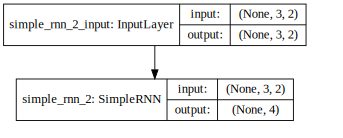

In [6]:
from   keras.models     import Sequential      # Слои в виде стопки
from   keras.layers     import SimpleRNN       # Рекуррентый слой

inputs   = 3                                   # число входов в RNN
features = 2                                   # размерность каждого входа x_t
units    = 4                                   # размерность выхода h_t

model = Sequential()
model.add(SimpleRNN(units=units, input_shape=(inputs,  features)))

print("Total params:", (features + units + 1) * units)
model.summary()
svg_model(model)

### Элементы матриц SimpleRNN

Получим значение элементов матриц (до обучения сети).<br> 
В списке  `get_weights()` порядок матриц следущий:  $\mathbf{W},\mathbf{H}, \mathbf{b}$:

In [307]:
features = 10      # размерность каждого входа x_t
units    = 32      # размерность выхода h_t

model = Sequential()
model.add(SimpleRNN(units=units, input_shape=(4,  features), name='rnn') )

model.compile(loss = 'mse', optimizer = "sgd") 

print(model.get_layer('rnn').get_weights())

shapes, i = [(features,units), (units,units), (units,)], 0
for w in model.get_layer('rnn').get_weights():   # слой и его веса по имени слоя
    print(w.dtype, w.shape, shapes[i])
    i += 1

[array([[-2.08850518e-01, -6.29467964e-02, -3.70163858e-01,
        -7.20109046e-02,  7.54415989e-02, -9.86678004e-02,
        -1.95624232e-02,  2.50017047e-02, -2.77229190e-01,
        -1.60751849e-01,  1.11324459e-01, -2.04831362e-04,
        -2.19363809e-01, -8.41945410e-04, -3.41345847e-01,
        -2.47054324e-01, -3.48892152e-01,  1.57979518e-01,
         1.04571342e-01,  1.80165142e-01, -3.52346927e-01,
         2.47052878e-01, -2.99255699e-01, -2.55447805e-01,
         3.24202448e-01, -1.16239339e-01, -2.62507796e-02,
         1.88869148e-01,  2.75236368e-02, -1.93798542e-02,
         9.96954441e-02, -1.54790193e-01],
       [ 1.34894699e-01,  1.55915171e-01,  1.28832728e-01,
         2.42041320e-01,  2.32032269e-01, -3.59363854e-02,
        -6.76725507e-02,  1.26614600e-01,  2.67262250e-01,
         8.96947980e-02, -2.44953051e-01,  3.68805319e-01,
        -2.91938722e-01, -3.56842875e-01,  1.68184429e-01,
         1.07767224e-01, -3.75344783e-01, -2.91926384e-01,
        -2.1

### Many-to-One
<a class="anchor" id="many-to-one"></a>

По умолчанию, Keras создаёт архитектуру слоя SimpleRNN типа many-to-one.
* слова на входе и один классификационный выход (позитивный или негативный текст)
* последовательность цен и прогноз следующей цены
* показания датчика и состояние объекта

Создадим сеть с `feautures = units = 1`, `inputs=3` и линейной активационной функцией.<br>
В этом случае $h_t = b + {x_t}\cdot W + h_{t-1}\cdot H$. Пусть $b=0,~W=H=1$.<br>
Это приводит к следующим простым вычислениям (выход сети $y = h_3$ - выход последней ячейки):

<div style="margin:30px; width: 200px; display:inline-block;">
$$
\begin{array}{ll}
 & h_0 = 0 \\
x_0 = 1,  &  h_1 = x_0 + h_0 = 1 + 0 = 1\\
x_1 = 2,  &  h_2 = x_1 + h_1 = 2 + 1 = 3\\
x_2 = 3,  &  h_3 = x_3 + h_2 = 3 + 3 = 6\\
\end{array}
$$
</div>
<div style="margin:10px; width: 200px; display: inline-block;">
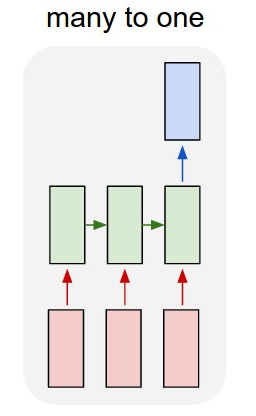
</div>
<div style="margin:10px; with:50px; display: inline-block;">
Архитектура "many-to-one" означает, что несколько векторных входов (слева красные блоки) поступают на связанные ячейки RNN (зелёные блоки), а выходом слоя служит только выход  последней ячейки (зелёный блок).
</div>

<div style="clear:both"></div>

res: [[6.]]


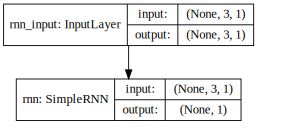

In [10]:
model = Sequential()
model.add(SimpleRNN(units=1, input_shape=(3,  1), activation=None, name='rnn') )
model.compile(loss = 'mse', optimizer = "sgd") 
                   
W, H, b  = np.array([[1]]), np.array([[1]]), np.array([0])
model.get_layer('rnn').set_weights(([ W, H, b ]))              # меняем веса

res = model.predict(np.array([ [ [1], [2], [3] ]] ))           # вычисляем вход

print("res:",res, )
svg_model(model)

### Many-to-Many
<a class="anchor" id="many-to-many"></a>

* слова в слова (перевод)

<div style="margin:5px; width:500px; float:left">
<p>
Если при задании слоя, положить <b>return_sequences = True</b>, то выходом слоя будет выход каждой ячеки (архитектура "<b>many-to-many</b>").
</p>
<p>
Ниже повторяются предыдущие вычисления. Результатом будет не одно число, а три.
Точнее, если раньше форма выхода была (None,1,1), то теперь это (None,3,1), т.е. три выхода размерности 1.
</p>
</div>
<div style="margin-left:40px; float:left">
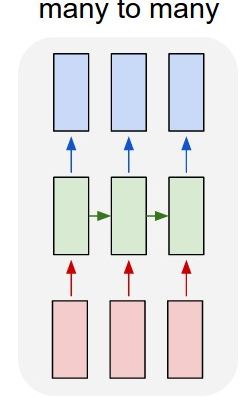
</div>

[[[1.]
  [3.]
  [6.]]]


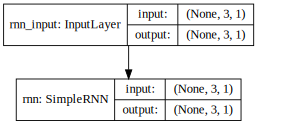

In [11]:
model = Sequential()
model.add(SimpleRNN(1,input_shape=(3,1),activation=None,return_sequences=True, name='rnn'))

model.compile(loss = 'mse', optimizer = "sgd") 

W, H, b  = np.array([[1]]), np.array([[1]]), np.array([0])
model.get_layer('rnn').set_weights(([ W, H, b ]))              # меняем веса

res = model.predict(np.array([ [ [1], [2], [3] ]] ))           # вычисляем вход

print(res)
svg_model(model)

## One-to-Many  копированием
<a class="anchor" id="one-to-many"></a>

* один вход (например, картинка) и несколько выходов (слова её описания)

<div style="margin:30px; width:300px; float:left ">
$$
\begin{array}{ll}
 & h_0 = 0 \\
x_0 = 1,  &  h_1 = x_0 + h_0 = 1 + 0 = 1\\
x_1 = 1,  &  h_2 = x_1 + h_1 = 1 + 1 = 2\\
x_2 = 1,  &  h_3 = x_3 + h_2 = 1 + 2 = 3\\
\end{array}
$$
</div>
<div style="margin:20px; width:250px;  float:left ">
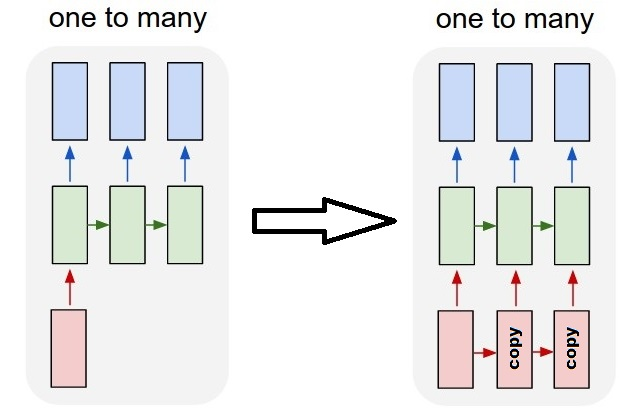
</div>
<div style="clear:both"></div>

[[[1.]
  [2.]
  [3.]]]


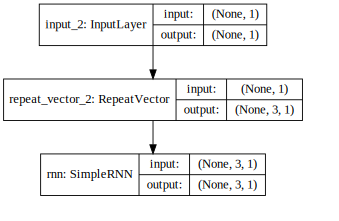

In [13]:
from keras.models import Model                      # для функционального способа
from keras.layers import Input, SimpleRNN, RepeatVector

inp = Input( shape=(1,) )                           # 1 вход сети (как input_shape)
out = RepeatVector(3)(inp)                          # 3 раза его повторяем
out = SimpleRNN(units=1, return_sequences=True, activation='linear', name='rnn')(out)

model = Model(inputs=inp, outputs=out)              # создаём модель

W, H, b  = np.array([[1]]), np.array([[1]]), np.array([0])
model.get_layer('rnn').set_weights(([ W, H, b ]))   # меняем веса

res = model.predict(np.array([ 1 ] ))               # вычисляем вход
print(res)
svg_model(model)

## stateful = True
<a class="anchor" id="one-to-many2"></a>

* `stateful=False`- каждый следующий batch содержит новые последовательности, независмые от предыдущих.
* `stateful=True` - каждый следующий batch содержит примеры, продолжающие туже последовательность из предыдущего batch. Это продолжается, пока не вызывают  `model.reset_states()`.

<div style="width:300px;float:left">
$$
\begin{array}{ll}
\mathrm{stateful} & \mathrm{=~False} \\
x_0 = 1,  &  h_1 = x_0 + h_0 = 1 + \mathbf{0} = 1\\
x_1 = 2,  &  h_2 = x_1 + h_1 = 2 + 1 = 3\\
x_2 = 3,  &  h_3 = x_3 + h_2 = 3 + 3 = \mathbf{6}\\
\hline
x_0 = 4,  &  h_4 = x_0 + h_3 = 4 + \mathbf{0} = 4\\
x_1 = 5,  &  h_2 = x_1 + h_1 = 5 + 4 = 9\\
x_2 = 6,  &  h_3 = x_3 + h_2 = 6 + 9 = \mathbf{15}\\
\end{array}
$$
</div>
<div style="margin-left:30px; width:300px;float:left">
$$
\begin{array}{ll}
\mathrm{stateful} & \mathrm{=~True} \\
x_0 = 1,  &  h_1 = x_0 + h_0 = 1 + \mathbf{0} = 1\\
x_1 = 2,  &  h_2 = x_1 + h_1 = 2 + 1 = 3\\
x_2 = 3,  &  h_3 = x_3 + h_2 = 3 + 3 = \mathbf{6}\\
\hline
x_0 = 4,  &  h_4 = x_0 + h_3 = 4 + \mathbf{6} = 10\\
x_1 = 5,  &  h_2 = x_1 + h_1 = 5 + 10 = 15\\
x_2 = 6,  &  h_3 = x_3 + h_2 = 6 + 15 = \mathbf{21}\\
\end{array}
$$
</div

In [14]:
model = Sequential()
model.add(SimpleRNN(units=1, batch_input_shape=(1, 3, 1), 
                    activation="linear", stateful = True, name='rnn') )

model.compile(loss = 'mse', optimizer = "sgd") 

W, H, b  = np.array([[1]]), np.array([[1]]), np.array([0])
model.get_layer('rnn').set_weights(([ W, H, b ]))              # меняем веса

res = model.predict(np.array([ [ [1], [2], [3] ]  ] )) 
print("res:",np.reshape(res, -1) )
res = model.predict(np.array([ [ [4], [5], [6] ]  ] )) 
print("res:",np.reshape(res, -1) )

res: [6.]
res: [21.]


## LSTM

### Теория
<a class="anchor" id="LSTM"></a>

Стандартные RNN плохо справляются с "договременными зависимостями", так как в основном ловят корреляции между соседними членами последовательности. Рекуррентная LSTM сеть лучше справляется с долговременными зависимостями.

Внутри LSTM-ячейки, вместо одного слоя нейронной сети как в SimpleRNN, существует четыре слоя. Сигмоидные слои $\sigma$ на выходе имеют вектор со значениями $[0...1]$, а гиперболический тангенс $\tanh$  - со значениями $[-1...1]$.

Верхняя линия ("скрытая" связь) $C_t$ между ячейками является состоянием ячеек и имеет размерность `units`, как и  $h_t$. Эти векторы регулируют какие фичи надо забыть, а какие запомнить при передаче к следующей ячейке. При помощи этого потока реализуется догосрочная память.

<div style="margin:30px">
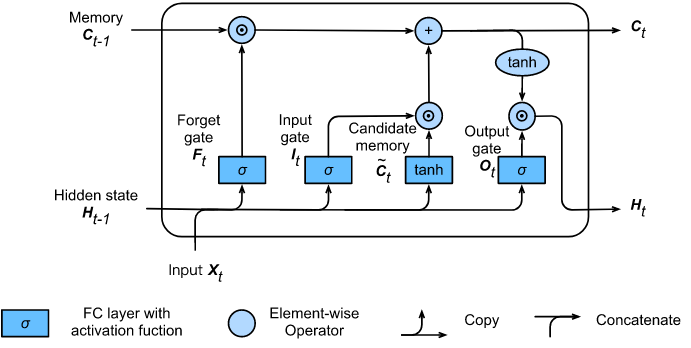
</div>

$$
\begin{array}{lcl}
\mathbf{I}_t &=& \sigma(\mathbf{X}_t \mathbf{W}_{xi} + \mathbf{H}_{t-1} \mathbf{W}_{hi} + \mathbf{b}_i),\\
\mathbf{F}_t &=& \sigma(\mathbf{X}_t \mathbf{W}_{xf} + \mathbf{H}_{t-1} \mathbf{W}_{hf} + \mathbf{b}_f),\\
\mathbf{O}_t &=& \sigma(\mathbf{X}_t \mathbf{W}_{xo} + \mathbf{H}_{t-1} \mathbf{W}_{ho} + \mathbf{b}_o),\\
\tilde{\mathbf{C}}_t &=& \text{tanh}(\mathbf{X}_t \mathbf{W}_{xc} + \mathbf{H}_{t-1} \mathbf{W}_{hc} + \mathbf{b}_c)\\
\mathbf{H}_t &=& \mathbf{O}_t \odot \tanh(\mathbf{C}_t).
\end{array}
$$

* <b>Forget gate layer</b>: "<i>She put on a <u>red hat</u> and a <u>green skirt</u></i>" (green после noun ослабляет red)
* <b>Гейт запоминания</b>: новый вариант выхода ($\tanh$) усиливается или ослабляется ($\sigma$)

$$\mathbf{W}_{xi}, \mathbf{W}_{xf}, \mathbf{W}_{xo}, \mathbf{W}_{xc} \in \mathbb{R}^{d \times h},~~~~
\mathbf{W}_{hi}, \mathbf{W}_{hf}, \mathbf{W}_{ho}, \mathbf{W}_{hc} \in \mathbb{R}^{h \times h},~~~
\mathbf{b}_i, \mathbf{b}_f, \mathbf{b}_o, \mathbf{b}_o \in \mathbb{R}^{1 \times h}$$

### Число параметров
<a class="anchor" id="LSTM_params"></a>

Если выход $h_t$ имеет размерность `(units,)`, а вход $x_t$ размерность `(features,)`, то <br>

* 4 матрицы $\mathbf{W}_{xi}, \mathbf{W}_{xf}, \mathbf{W}_{xo}, \mathbf{W}_{xc}$ 
Keras упаковывает в одну, получая размерности `(features, 4*units)` и 
* 4 матрицы $\mathbf{W}_{hi}, \mathbf{W}_{hf}, \mathbf{W}_{ho}, \mathbf{W}_{hc}$ 
Keras упаковывает в одну, получая размерности `(units, 4*units)`. 
* 4 вектора $\mathbf{b}_o, \mathbf{b}_f, \mathbf{b}_i, \mathbf{b}_c,$ упакованные в один длины `4*units`.

Поэтому get_weight(), как и в SimpleRNN имеет 2 матрицы и 1 вектор.
Общее число параметров в ячейке LSTM равно `(features+units+1)*4*units`

In [16]:
from   keras.models     import Sequential  
from   keras.layers     import LSTM

units     = 10
features  = 2

model = Sequential()
model.add(LSTM(units=units, input_shape=(4, features), name='rnn') )
model.compile(loss = 'mse', optimizer = "sgd") 

shapes, i = [(features, 4*units), (units, 4*units), (4*units,)], 0
for w in model.get_layer('rnn').get_weights():   # слой и его веса по имени слоя
    print("%-10s %-10s" % (str(w.shape), str(shapes[i])) )
    i += 1

print("params:", (features+units+1)*4*units)
model.summary()

(2, 40)    (2, 40)   
(10, 40)   (10, 40)  
(40,)      (40,)     
params: 520
Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rnn (LSTM)                   (None, 10)                520       
Total params: 520
Trainable params: 520
Non-trainable params: 0
_________________________________________________________________


### Активационные функции
<a class="anchor" id="LSTM_activ"></a>

Активационные функции в Keras LSTM задаются параметрами:
* `activation`: Default: `tanh`.
* `recurrent_activation`:  to use for the recurrent step. Default: `hard_sigmoid`. 

If you pass `None`, no activation is applied (ie. "linear" activation: `a(x) = x`).

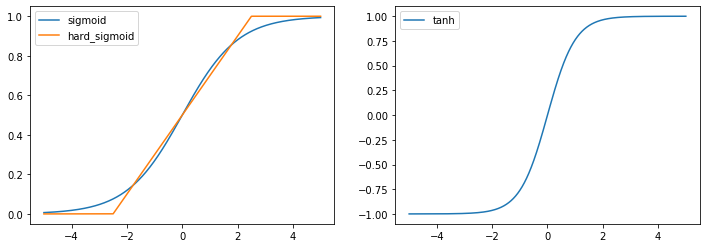

In [308]:
import numpy  as np
import matplotlib.pyplot as plt

x = np.linspace(-5,5, 1000)

plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
plt.plot(x,1/(1+np.exp(-x)))
plt.plot(x,np.where(x < -2.5, 0, np.where(x < 2.5, 0.2*x + 0.5, 1)))
plt.legend(['sigmoid', 'hard_sigmoid'])

plt.subplot(1, 2, 2)
plt.plot(x,np.tanh(x))
plt.legend(['tanh'])
plt.show()

##  Gated recurrent unit (GRU)

* **Update gate**: The update gate decides how much of previous memory to keep around.
* **Reset Input**: The reset gate defines how to combine new input with previous value.


<div style="margin:30px">
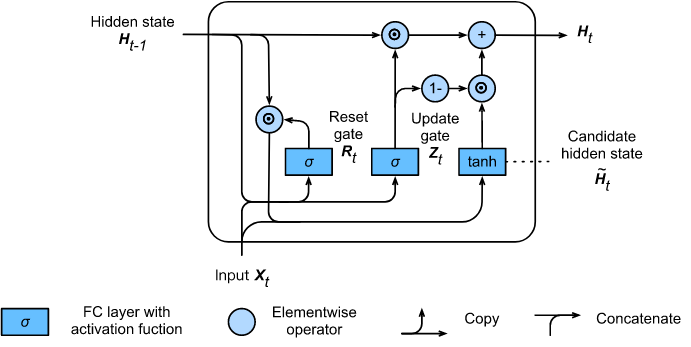
</div>

$$
\begin{array}{lcl}
\mathbf{R}_t &=& \sigma(\mathbf{X}_t \mathbf{W}_{xr} + \mathbf{H}_{t-1} \mathbf{W}_{hr} + \mathbf{b}_r)\\
\mathbf{Z}_t &=& \sigma(\mathbf{X}_t \mathbf{W}_{xz} + \mathbf{H}_{t-1} \mathbf{W}_{hz} + \mathbf{b}_z)\\
\tilde{\mathbf{H}}_t &=& \tanh(\mathbf{X}_t \mathbf{W}_{xh} + \left(\mathbf{R}_t \odot \mathbf{H}_{t-1}\right) \mathbf{W}_{hh} + \mathbf{b}_h)\\
\mathbf{H}_t &=& \mathbf{Z}_t \odot \mathbf{H}_{t-1}  + (1 - \mathbf{Z}_t) \odot \tilde{\mathbf{H}}_t.
\end{array}
$$


**GRU v/s LSTM**
* GRU and LSTM have comparable performance.
* GRU’s are faster to train and need fewer data to generalize.
* When there is enough data, an LSTM’s greater expressive power may lead to better results.
* Like LSTMs, GRUs are drop-in replacements for the SimpleRNN cell.

# <center>Примеры</center>

## Генерация текстов

In [205]:
import numpy as np
import re

with open("Data/NLP/saltan.txt", "r", encoding='utf-8-sig') as file:
    text = file.read()
    
text = text.lower()
text = text.translate( {ord(c): " " for c in "…—–-«»"} )
text = text.translate( {769: ' '} )
text = re.sub( '\s+\.', '.', text )
text = re.sub( '\s+', ' ', text ).strip()

chars = sorted(set( [c for c in text] ))            # все символы текста
n_chars = len(chars)                                # число символов
ch2id = dict( (c,i) for i,c in enumerate(chars))    # таблица перевода char -> index
id2ch = dict( (i,c) for i,c in enumerate(chars))    # таблица перевода index -> char  
print()
print(n_chars, "\n", chars, "\n", len(text), "\n", text[:1000])


42 
 [' ', '!', ',', '.', ':', ';', '?', 'e', 'x', 'а', 'б', 'в', 'г', 'д', 'е', 'ж', 'з', 'и', 'й', 'к', 'л', 'м', 'н', 'о', 'п', 'р', 'с', 'т', 'у', 'ф', 'х', 'ц', 'ч', 'ш', 'щ', 'ъ', 'ы', 'ь', 'э', 'ю', 'я', 'ё'] 
 23314 
 три девицы под окном пряли поздно вечерком. кабы я была царица, говорит одна девица, то на весь крещеный мир приготовила б я пир. кабы я была царица, говорит ее сестрица, то на весь бы мир одна наткала я полотна. кабы я была царица, третья молвила сестрица, я б для батюшки царя родила богатыря. только вымолвить успела, дверь тихонько заскрипела, и в светлицу входит царь, стороны той государь. во все время разговора он стоял позадь забора; речь последней по всему полюбилася ему. здравствуй, красная девица, говорит он, будь царица и роди богатыря мне к исходу сентября. вы ж, голубушки сестрицы, выбирайтесь из светлицы, поезжайте вслед за мной, вслед за мной и за сестрой: будь одна из вас ткачиха, а другая повариха. в сени вышел царь отец. все пустились во дворец. ц

In [218]:
SEQ_LEN = 10                           # длина истории (символов перед c_i)
n_data  = len(text) - SEQ_LEN          # число примеров

X = np.empty( (n_data, SEQ_LEN)  )     # индексы символов истории
Y = np.zeros( (n_data, n_chars)  )     # вероятности символа после него (one-hot)
for i in range(n_data):
    st, ch = text[i:i+SEQ_LEN], text[i+SEQ_LEN]
    if i < 5: 
        print(st,"->",ch)
    for j in range(SEQ_LEN): 
        X[i,j]  = ch2id[st[j]]
    Y[i, ch2id[ch]] = 1

три девицы ->  
ри девицы  -> п
и девицы п -> о
 девицы по -> д
девицы под ->  


In [314]:
from   keras.models     import Sequential  
from   keras.layers     import SimpleRNN, LSTM, GRU

VEC_DIM = 8

model = Sequential()
model.add(Embedding(n_chars, VEC_DIM, input_length=SEQ_LEN))
#model.add(GRU ( 128, dropout = 0.2, recurrent_dropout = 0.2 ) )
model.add(LSTM ( 128 ) )
model.add(Dense(n_chars, activation="softmax")) 
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])    

model.summary()


Model: "sequential_113"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_26 (Embedding)     (None, 10, 8)             336       
_________________________________________________________________
lstm_77 (LSTM)               (None, 128)               70144     
_________________________________________________________________
dense_157 (Dense)            (None, 42)                5418      
Total params: 75,898
Trainable params: 75,898
Non-trainable params: 0
_________________________________________________________________


In [315]:
hist = model.fit(X,Y, validation_split=0.2, batch_size=32, epochs=100, verbose=2)

for label in ["loss","val_loss"]:               # рисуем ошибку обучения:
    plt.plot(hist.history[label], label=label)
plt.xlabel("epoch")            
plt.legend()
plt.show()          

Train on 18643 samples, validate on 4661 samples
Epoch 1/100
 - 32s - loss: 3.1225 - accuracy: 0.1754 - val_loss: 2.9702 - val_accuracy: 0.1927
Epoch 2/100
 - 31s - loss: 2.8037 - accuracy: 0.2225 - val_loss: 2.6661 - val_accuracy: 0.2386
Epoch 3/100
 - 28s - loss: 2.5820 - accuracy: 0.2530 - val_loss: 2.5245 - val_accuracy: 0.2637
Epoch 4/100
 - 29s - loss: 2.4780 - accuracy: 0.2780 - val_loss: 2.4394 - val_accuracy: 0.2851
Epoch 5/100
 - 29s - loss: 2.3924 - accuracy: 0.3009 - val_loss: 2.3569 - val_accuracy: 0.3064
Epoch 6/100
 - 29s - loss: 2.3110 - accuracy: 0.3210 - val_loss: 2.2842 - val_accuracy: 0.3321
Epoch 7/100
 - 29s - loss: 2.2285 - accuracy: 0.3493 - val_loss: 2.2202 - val_accuracy: 0.3596
Epoch 8/100
 - 28s - loss: 2.1428 - accuracy: 0.3763 - val_loss: 2.1494 - val_accuracy: 0.3860
Epoch 9/100
 - 29s - loss: 2.0554 - accuracy: 0.4030 - val_loss: 2.0896 - val_accuracy: 0.4083
Epoch 10/100
 - 28s - loss: 1.9679 - accuracy: 0.4302 - val_loss: 2.0370 - val_accuracy: 0.4334


KeyboardInterrupt: 

In [316]:
def gen(st, num, end="\n"):  
    if len(st) < SEQ_LEN: 
        st = (" " * (SEQ_LEN-len(st))) + st 
        
    X_tst = np.empty( (1, SEQ_LEN) )
    for i in range( SEQ_LEN ):        
        X_tst[0,i] = ch2id[st[len(st)-SEQ_LEN+i]]

    for i in range(num):
        id = np.argmax( model.predict(X_tst, verbose=0)[0] )        
        st += id2ch[id]
        for j in range(1,SEQ_LEN):                   # сдвигаем
            X_tst[0,j-1] = X_tst[0,j]
        X_tst[0,SEQ_LEN-1] = id                      # последним ставим прогноз
    
    print(st+"|",end=end)

for st in ["княз", "зелёны", "сексуально", "умн","красив", "электр"]:
    gen(st, 2, " ")
print()
for s in ["положили молодых ", "мама мыла раму "]:
    gen(str(s), 256)

      князпа|     зелёныви| сексуально т|        умнон|     красивно|     электрой| 
положили молодых ие ст те остихает, сто нечко нечь соднамочиц на до весдогих, с огвитон но зарешь те голонье богоро. имуе злеват: он стой ет бовой итой вы зюбемает оне госпола, волги поша, в семуе жетят нам подег севороми, под не, не жутун. тетна весь не весдают изум хости|
мама мыла раму нев у дабой причисаль вела хорорьщи и придау цара салтану в нере корту а негегостряла, вот и ен берег ой залов провет и отит доробой престаль бебода пушкой на поредке боспа ервали: те граба их енваму мишод иневыйшид весте веб, стори то, и плисая волжаа кня|


2, 64<br>
      князь |     зелёный | сексуальной |        умной|     красива |     электро |  <br> 
положили молодых ответа ве во море салтан и в свать боро салтан и в свать боро салтан

10, 128<br>
князь |     зелёный | сексуальной |        умно |     красиве |     электрой| <br>
положили молодых подом слогой пристали в свой гости подетель бель присталь с пристали

Epoch 100/100 - 34s - loss: 1.6634 - accuracy: 0.5096 - val_loss: 1.6785 - val_accuracy: 0.5480

## Временные ряды
<a class="anchor" id="time_series"></a>
### Класс TimeSeries
<a class="anchor" id="ts_class"></a>


In [148]:
import numpy             as np
import matplotlib.pyplot as plt
from   keras.models     import Sequential  
from   keras.layers     import Embedding, SimpleRNN, Dense, Dropout

class TimeSeries():     
    def __init__(self, series):
        self.series = series
            
    def prepare_data(self, step=10, lrn_frac=0.8 ):
        """ 
        Подготавливаем обучающие и тестовые данные.
        step - длина истории для предсказания, lrn_frac - доля обучающих примеров
        Будем предсказывать по step предыдущим шагам  𝑥(𝑡−𝑠),...,𝑥(𝑡−1)  следующий  𝑥(𝑡)
        """
        self.step = step
        data_X, data_Y = np.array([]), np.array([])
        for i in range(step, len(self.series)):
            data_X = np.append(data_X, self.series[i-step:i] )
            data_Y = np.append(data_Y, self.series[i] ) 

        data_X = data_X.reshape(data_Y.shape[0], step, 1)
    
        lrn_N  = int(lrn_frac*len(self.series))        # число обучающих данных     
        self.lrn_X = data_X[:lrn_N];    self.tst_X = data_X[lrn_N:]
        self.lrn_Y = data_Y[:lrn_N];    self.tst_Y = data_Y[lrn_N:]
        
    def create_model(self, kind = 0,  show = False):
        """ 
        Создаём модель many-to-one: SimpleRNN if simple else LSTM
        kind - различные варианты архитектуры
        """
        model = Sequential()
        if   kind == 0:
            model.add(SimpleRNN(units=32, input_shape=(self.step,1), activation="tanh"))            
        elif kind == 1:
            model.add(LSTM     (units=32, input_shape=(self.step,1) ) )
        else:
            model.add(LSTM     (units=64, input_shape=(self.step,1), return_sequences = True ) )
            model.add(LSTM     (units=32, input_shape=(self.step,32) ) )
        model.add(Dense(16, activation="tanh")) 
        model.add(Dropout(0.2))
        model.add(Dense(1))                                # "linear" activation 
        model.compile(loss='mean_squared_error', optimizer='rmsprop')        
        
        if show:
            model.summary()
            svg_model(model)        
        self.model = model
        
    def train_model(self, epochs=20, batch_size=16, verbose=0):
        """ Обучение нейронной сети """
        hist = self.model.fit(self.lrn_X, self.lrn_Y, 
                              validation_data=(self.tst_X, self.tst_Y),
                 epochs=epochs, batch_size=batch_size, verbose=verbose)
        
        print("lrn: %.3E" % ( self.model.evaluate(self.lrn_X, self.lrn_Y, verbose=0)  ))
        print("tst: %.3E" % ( self.model.evaluate(self.tst_X, self.tst_Y, verbose=0)  ))
        
        for label in ["loss","val_loss"]:               # рисуем ошибку обучения:
            plt.plot(hist.history[label], label=label)
        plt.xlabel("epoch")            
        plt.legend()
        plt.show()          
         
    def show_test1(self, num=100):
        if num + self.step > self.tst_X.shape[0] : num = self.tst_X.shape[0] - self.step
        
        predict = self.model.predict(self.tst_X[:num,:])        
        
        t = np.arange(0, len(self.series))         
        t_tst = len(self.lrn_X) + self.step
        plt.figure(figsize=(16,4))     
        plt.scatter(t[t_tst: t_tst+num],   self.series[t_tst: t_tst+num], s=8)
        plt.plot   (t[t_tst: t_tst+num],   predict)
        plt.title('predict tst series')
        plt.show() 
        
    def show_test2(self, num=100):
        """
        Начнём с первых step значений ряда и при помощи сети восстановим все точки.
        """
        if num + self.step > len(self.series) : num = len(self.series) - self.step
        step = self.step
        hist, fut_x = self.series[:step].copy(), []
        hist = hist.reshape(1,step, 1)
        for i in range(num):
            nxt_x = self.model.predict( hist )[0]            
            for j in range(1,step):                   # сдвигаем
                hist[0,j-1,0] = hist[0,j,0]
            hist[0,step-1,0] = nxt_x                  # последним ставим прогноз
            fut_x.append(nxt_x)

        fut_x = np.array(fut_x)
        print(fut_x.shape)

        t = np.arange(0,len(self.series))     
        plt.figure(figsize=(16,4))     
        plt.scatter(t[step:num+step], self.series[step:num+step], s=8)
        plt.plot   (t[step:num+step], fut_x)
        plt.title('reconstruction lrn series')
        plt.show() 

### Периодическая функция
<a class="anchor" id="ts1"></a>

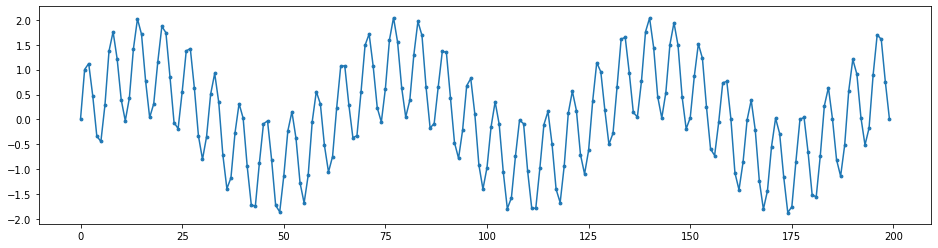

In [146]:
import numpy  as np
import matplotlib.pyplot as plt

N = 1000                                               # число точек
t = np.arange(0,N)                                     # 0,1,2,...,N-1 - ось времени
x = np.sin(0.1*t)+np.sin(t) +0.1*np.random.rand(N)     # значения временного ряда

N_out = 200
plt.figure(figsize=(16,4))                             # расширяем картинку
plt.plot   (t[:N_out], x[:N_out])
plt.scatter(t[:N_out], x[:N_out], s=8)
plt.show() 

lrn: 3.415E-03
tst: 3.585E-03


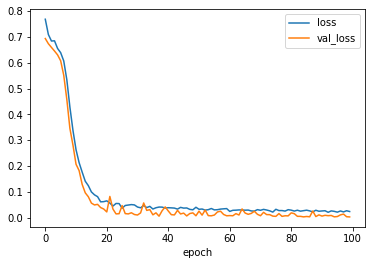

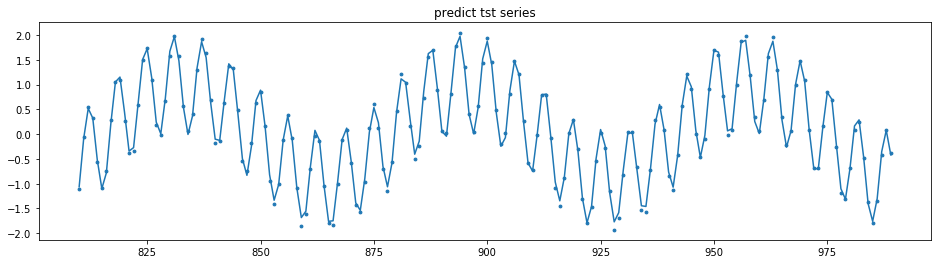

(200, 1)


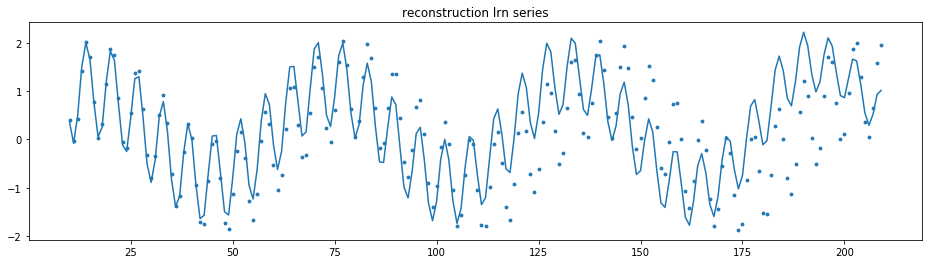

(800, 10, 1) (190, 10, 1) (800,)


In [155]:
ts = TimeSeries(x)
ts.prepare_data(step = 10)
ts.create_model(kind =  1)
ts.train_model (epochs=100, batch_size=64)
ts.show_test1(num=200)
ts.show_test2(num=200)

print(ts.lrn_X.shape, ts.tst_X.shape, ts.lrn_Y.shape)        

### Выводы
* Если число перегибов маленькое: `x = np.sin(0.02*t)`, то сеть не научится предсказывать перегибы. Чтобы она это научилась делать их должно быть много.
* Чем больше `step`, тем, ественно, лучше предсказание. Например, при `step=10` график выше существенно лучше, чем при `step=5`. Однако можгут возникнуть эффекты переобучения (?)

### Курс акций Apple
<a class="anchor" id="ts2"></a>

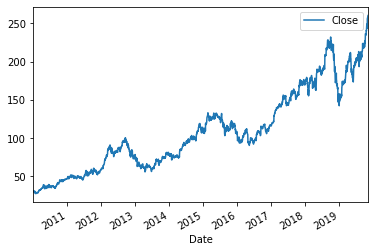

In [157]:
from pandas_datareader import data
import matplotlib.pyplot as plt
import pandas as pd

df = data.DataReader('AAPL', 'yahoo', '2010-01-01', '2019-11-8')
close = df.loc[:, ['Close']]
close.plot()
plt.show()

close = df.to_numpy()[:,1]                       # цены закрытия

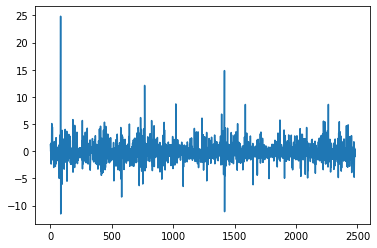

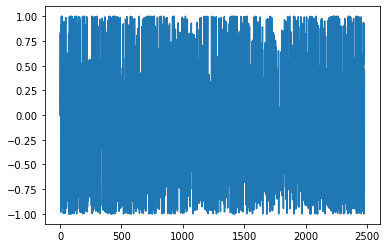

In [161]:
from scipy.ndimage.interpolation import shift
close2 = shift(close, 1, cval=np.NaN)[1:]          # сдвигаем вперед на 1 элемент      
close  = close[1:]
delta  = 100*(close2-close)/close                  # процентное изменение цены
plt.plot(delta)
plt.show()

delta = np.tanh(delta)
plt.plot(delta)
plt.show()


lrn: 4.285E-01
tst: 4.967E-01


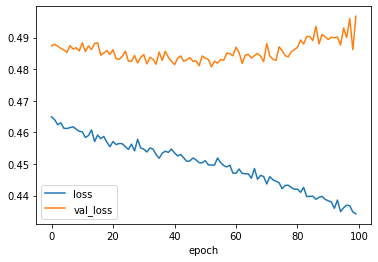

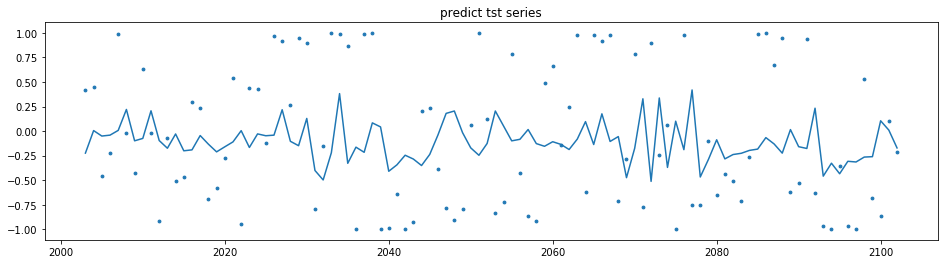

(100, 1)


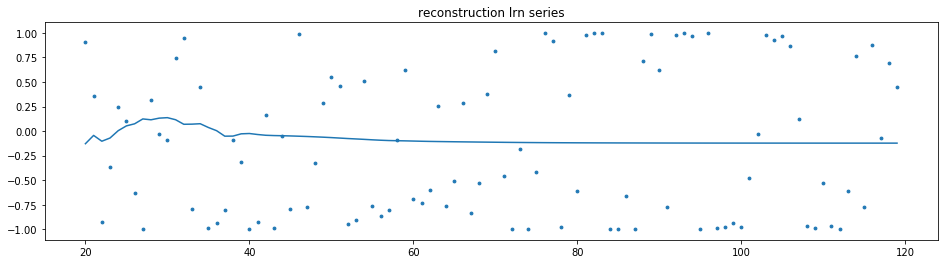

(1983, 20, 1) (476, 20, 1) (1983,)


In [163]:
ts = TimeSeries(delta)
ts.prepare_data(step=20)
ts.create_model(kind = 1)
ts.train_model (epochs=100, batch_size=32)
ts.show_test1()
ts.show_test2()

print(ts.lrn_X.shape, ts.tst_X.shape, ts.lrn_Y.shape)        

## MNIST
<a class="anchor" id="MNIST"></a>

Rowel Atienza - "*Advanced Deep Learning with Keras_ Apply deep learning techniques, autoencoders, GANs, variational autoencoders, deep reinforcement learning, policy gradients, and more.*"

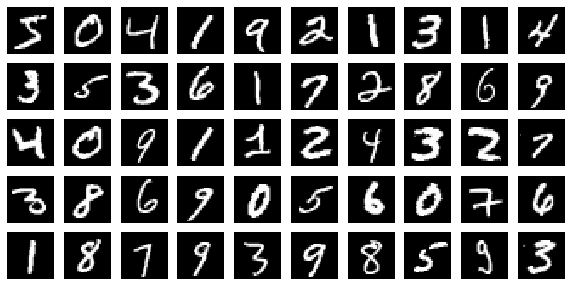

(10000, 28, 28) (10000,)->

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist

# load mnist dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

plt.figure(figsize=(10, 5))         # plot the 50 mnist digits
for i in range(50):
    plt.subplot(5, 10, i + 1)    
    plt.imshow(x_train[i,:,:], cmap='gray')
    plt.axis('off')
plt.show()

print(x_test.shape, y_test.shape, end='->')

In [40]:
from keras.utils    import to_categorical, plot_model

image_size = x_train.shape[1]                  # размер картинки
num_labels = len(np.unique(y_train))           # вычисляем число классов

x_train = x_train.astype('float32') / 255      # нормируем на [0...1]
x_test  = x_test.astype ('float32') / 255

y_train = to_categorical(y_train)              # переводим в one-hot вектор
y_test  = to_categorical(y_test)
        
print(x_test.shape, y_test.shape)
print("num_labels: %d\nimage_size: %d" % (num_labels,image_size))

(10000, 28, 28) (10000, 10)
num_labels: 10
image_size: 28


* **dropout**: Float between 0 and 1. Fraction of the units to drop for the linear transformation of the inputs.

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_7 (SimpleRNN)     (None, 256)               72960     
_________________________________________________________________
dense_15 (Dense)             (None, 10)                2570      
Total params: 75,530
Trainable params: 75,530
Non-trainable params: 0
_________________________________________________________________


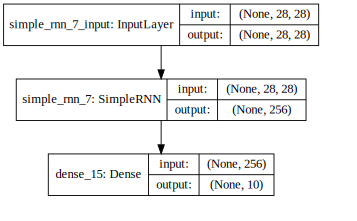

In [41]:
from keras.models   import Sequential
from keras.layers   import Dense, Activation, SimpleRNN

model = Sequential()

model.add(SimpleRNN(units   = 256,
                    dropout = 0.2 ,        
                    input_shape = (image_size, image_size) ))   #  timesteps   input
model.add(Dense(num_labels, activation='softmax'))

model.summary()

plot_model(model, to_file='rnn-mnist.png', show_shapes=True)
svg_model (model)

model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

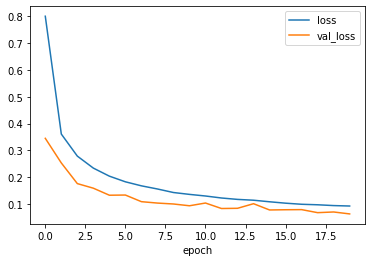

10000/10000 [==============================] - 1s 90us/step

Test accuracy: 98.1%


In [42]:
batch_size  = 128

hist = model.fit(x_train, y_train,  validation_data=(x_test, y_test),
                 batch_size=batch_size, epochs=20, verbose=0)

for label in ["loss","val_loss"]:
    plt.plot(hist.history[label], label=label)
plt.xlabel("epoch")
plt.legend()
plt.show() 

loss,  acc = model.evaluate(x_test, y_test, batch_size=batch_size)
print("\nTest accuracy: %.1f%%" % (100.0 * acc))

## Обучение с stateful=True
<a class="anchor" id="stateful_example"></a>

Демонстрируем работу длинной памяти.<br>
Есть длинная (max_len) последовательность чисел, состоящая из нулей, кроме первого элемента,
который может быть 0 или 1. Если он 0 - то это класс 0, если 1 - то класс 1.<br>
Если `x_t = [1,0,0,0,0,0]` `y=1`, разбивать  последовательность на временные шаги длиной 3:<br>
`x = [1,0,0], y=1;  x = [0,0,0], y=1`,..., то рекуррентная сеть ни чему не научится.<br>
В этом случае необходимо использовать `stateful=True`.

In [43]:
import numpy as np 
from numpy.random import choice

n_data  = 100                     # число примеров
n_test  = int(n_data*0.8)         # число обучающих примеров
max_len = 20                      # длина x_t каждого примера

X_data, Y_data = np.zeros((n_data, max_len)), np.zeros((n_data,))

one_indexes = choice(a=n_data, size=int(n_data / 2), replace=False) # половина случ. индексов
X_data[one_indexes, 0] = 1                                          # для них первый элемент 1
Y_data[one_indexes] = 1                                             # и класс 1

print(X_data[:10,:],"\n", Y_data[:10])

X_lrn, Y_lrn = X_data[:n_test,:], Y_data[:n_test]
X_tst, Y_tst = X_data[n_test:,:], Y_data[n_test:]

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]] 
 [0. 0. 1. 1. 1. 0. 1. 1. 1. 1.]


Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (1, 10)                   480       
_________________________________________________________________
dense_17 (Dense)             (1, 1)                    11        
Total params: 491
Trainable params: 491
Non-trainable params: 0
_________________________________________________________________


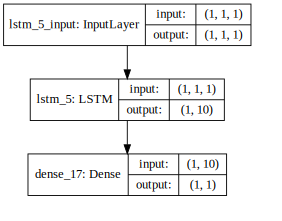

In [45]:
from   keras.models     import Sequential  
from   keras.layers     import LSTM, Dense

model = Sequential()
model.add(LSTM(10, batch_input_shape=(1, 1, 1), return_sequences=False, stateful=True))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()
svg_model(model)

In [47]:
print('Train...')
for epoch in range(3):
    lrn_acc, lrn_loss = [], []                   # обучаем:
    for i in range(len(X_lrn)):                  # i-й пример
        for j in range(max_len):                 # бежим по нему
            loss, acc = model.train_on_batch( np.array([[[ X_lrn[i][j] ]]]), 
                                                    np.array(   [Y_lrn[i]]))
            lrn_acc.append(acc)
            lrn_loss.append(loss)
        model.reset_states()                      # сбрасываем память

    print('%2d:\nlrn acc: %.5f,  loss:%.5f' % (epoch+1, np.mean(lrn_acc),np.mean(lrn_loss)))

    tst_acc, tst_loss, tst_prob = [],[],[]        # тестируем:
    for i in range(len(X_tst)):                   # i-й пример
        for j in range(max_len):
            loss, acc = model.test_on_batch(np.array([[[ X_tst[i][j] ]]]),
                                            np.array(   [Y_tst[i]]))
            tst_acc.append(acc)
            tst_loss.append(loss)
        model.reset_states()                      # сбрасываем память

        for j in range(max_len):
            y_pred = model.predict_on_batch(np.array([[[ X_tst[i][j] ]]]) )[0,0]
            tst_prob.append(float(int(y_pred > 0.5) == int(Y_tst[i])))
        model.reset_states()

    print('tst acc: %.5f,  loss:%.5f  prob:%.5f' % (np.mean(tst_acc), np.mean(tst_loss), np.mean(tst_prob)) ) 

Train...
 1:
lrn acc: 0.70938,  loss:0.56956
tst acc: 1.00000,  loss:0.11970  prob:1.00000
 2:
lrn acc: 1.00000,  loss:0.04067
tst acc: 1.00000,  loss:0.01515  prob:1.00000
 3:
lrn acc: 1.00000,  loss:0.00941
tst acc: 1.00000,  loss:0.00536  prob:1.00000
